In [1]:
import numpy as np
from numpy.linalg import norm
from itertools import combinations

# def foo(Q):
#     _, k = Q.shape
#     res = np.zeros_like(Q)
#     q = Q[:, 0]
#     print(q)
#     res[:, 0] =  q / norm(q)
#     res[0, 0] = 1
#     print(res)

#     for i in range(1, k):
#         O_i = res[:, :i]
#         q = Q[:, i]
#         print(q)
#         q_orth = q - O_i.dot(O_i.T.dot(q))
#         res[:, i] =  q_orth / norm(q_orth)
#     return res

def orthonormalization(Q):
    n, k = Q.shape
    O = np.zeros(shape=(n, k))
    q = Q[:, 0]
    O[:, 0] =  q / norm(q)

    for i in range(1, k):
        O_i = O[:, :i]
        q = Q[:, i]
        q_orth = q - O_i.dot(O_i.T.dot(q))
        O[:, i] =  q_orth / norm(q_orth)
    return O

def non_empty_subset_indicator(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            yield col

class instance:

    @staticmethod
    def random(n, t, seed=None):
        rng = np.random.default_rng(seed)
        Q = rng.binomial(1, 0.5, size=(n, t))
        g = rng.normal(size=n)
        return instance(Q, g)

    def __init__(self, Q, g, keep_bf_queries=False):
        n, k = Q.shape
        self.n = n
        self.k = k
        self.Q = Q
        self.O = orthonormalization(Q)
        self.g = g
        self.P = self.O.dot(self.O.T)
        self.M = np.eye(n) - self.P
        self.g = self.M.dot(g)
        self.keep_bf_queries = keep_bf_queries

    def orth_part_norm(self, queries):
        return norm(self.M.dot(queries))

    def selected_grad_elements(self, q):
        return np.sort(self.g[np.flatnonzero(q)])

class result:

    def __init__(self, q_star, f_star, q_seq, inst):
        self.q_star = q_star
        self.f_star = f_star
        self.q_seq = q_seq
        self.inst = inst

    def print_selected_elements_by_score(self, q=None, score=None, end='\n', sep=' '):
        q = self.q_star if q is None else q
        score = self.inst.g if score is None else score
        order = np.argsort(score)[::-1]
        for i in range(self.inst.n):
            s = f'\x1b[31m{score[order[i]]:.3f}\x1b[0m' if q[order[i]] else f'{score[order[i]]:.3f}'
            print(s, end=sep if i<self.inst.n-1 else '')
        print(end, end='')

def brute_force(self, epsilon=0):
    if self.keep_bf_queries:
        bf_queries = np.zeros(shape=(2**self.n-1, self.n))
    bf_gsum_ = np.zeros(2**self.n-1)
    bf_opn_ = np.zeros(2**self.n-1)
    bf_norms_ = np.zeros(2**self.n-1)

    i_star = -1
    obj_star = float('-inf')
    q_star = None

    for i, q in enumerate(non_empty_subset_indicator(self.n)):
        if self.keep_bf_queries:
            bf_queries[i, :] = q
        bf_gsum_[i]=self.g.dot(q)
        bf_opn_[i]=self.orth_part_norm(q)
        bf_norms_[i]=norm(q)
        
        obj = (bf_gsum_[i]**2 / (bf_opn_[i] + epsilon)**2) if epsilon!=0 or bf_opn_[i]>1e-5 else 0
        if obj > obj_star:
            i_star = i
            q_star = q
            obj_star = obj

    res = result(q_star, obj_star, bf_queries if self.keep_bf_queries else None, self)
    res.i_star = i_star
    res.gsums = bf_gsum_
    res.op_norms = bf_opn_
    res.norms = bf_norms_

    return res

    


### Objective Function is Bounded by Squared Norm of Gradient

We can bound the objective function by decomposing $q_\perp$ into components parallel and orthogonal to the gradient vector, i.e.,
\begin{equation*}
q_\perp = q_{\perp\parallel} + q_{\perp\perp}\\
\end{equation*}
where
\begin{equation*}
q_{\perp\parallel} = \frac{q_\perp^Tg}{\|g\|^2}g \enspace .
\end{equation*}

Indeed, by observing that $\|q_{\perp\parallel}\|^2=(g^Tq)^2/\|g\|^2$ we can conclude that
\begin{align*}
\frac{(g^Tq)^2}{\|q_\perp\|^2} &= \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2 + \|q_{\perp\perp}\|^2}\\
&\leq \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2}\\
&=\|g\|^2
\end{align*}


In [2]:
import numpy as np
from numpy.linalg import norm
n=20
k=100
kk=5
RNG = np.random.default_rng(k)
Q = RNG.binomial(1, 0.5, size=(n, k))
g = RNG.normal(size=n)
inst1 = instance(Q[:, :kk], g)

In [3]:
def orthogonalize(U, eps=1e-15):
    n = len(U[0])
    V = np.array(U.T)
    for i in range(n):
        prev_basis = V[0:i]
        coeff_vec = np.dot(prev_basis, V[i].T)
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if np.linalg.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.
        else:
            V[i] /= np.linalg.norm(V[i])
    return V.T

In [4]:
A=np.random.random((100, 100))*10
A

array([[5.45267448, 0.24026865, 2.53263446, ..., 3.3026671 , 6.16708887,
        4.09022472],
       [6.62665337, 5.34519377, 7.06985767, ..., 9.82524876, 3.59520877,
        9.54597565],
       [6.62959502, 8.87613574, 8.33821882, ..., 7.01488816, 0.06104428,
        4.08080087],
       ...,
       [6.31608024, 3.84060668, 9.13544637, ..., 8.16519541, 1.19775796,
        8.82401409],
       [3.00396613, 0.25730433, 4.89466446, ..., 0.50076972, 2.81809034,
        7.70449514],
       [6.51334324, 4.31104087, 0.6752531 , ..., 5.60716537, 5.05042352,
        6.08262004]])

In [5]:
orthonormalization(A).T@orthonormalization(A)

array([[ 1.00000000e+00, -4.16157005e-18, -1.21621839e-17, ...,
        -7.10646379e-16,  1.06932459e-15, -6.77375526e-15],
       [-4.16157005e-18,  1.00000000e+00, -1.21871746e-16, ...,
        -3.01522255e-15,  2.21191208e-15, -2.30418123e-15],
       [-1.21621839e-17, -1.21871746e-16,  1.00000000e+00, ...,
         5.91670266e-16, -3.08569489e-15, -3.44495534e-15],
       ...,
       [-7.10646379e-16, -3.01522255e-15,  5.91670266e-16, ...,
         1.00000000e+00,  1.10663178e-14,  1.38973224e-13],
       [ 1.06932459e-15,  2.21191208e-15, -3.08569489e-15, ...,
         1.10663178e-14,  1.00000000e+00, -9.85057303e-14],
       [-6.77375526e-15, -2.30418123e-15, -3.44495534e-15, ...,
         1.38973224e-13, -9.85057303e-14,  1.00000000e+00]])

In [6]:
orthogonalize(A).T@orthogonalize(A)

array([[ 1.00000000e+00, -4.16157005e-18, -3.47135891e-17, ...,
        -2.17714061e-15,  1.03073665e-15, -7.78580187e-15],
       [-4.16157005e-18,  1.00000000e+00, -1.22413847e-16, ...,
        -7.45739212e-16,  2.46269244e-15,  1.37651292e-16],
       [-3.47135891e-17, -1.22413847e-16,  1.00000000e+00, ...,
         8.16173843e-16, -1.90662105e-16, -5.21843126e-16],
       ...,
       [-2.17714061e-15, -7.45739212e-16,  8.16173843e-16, ...,
         1.00000000e+00,  2.43059597e-13, -6.60252348e-14],
       [ 1.03073665e-15,  2.46269244e-15, -1.90662105e-16, ...,
         2.43059597e-13,  1.00000000e+00,  2.64789531e-13],
       [-7.78580187e-15,  1.37651292e-16, -5.21843126e-16, ...,
        -6.60252348e-14,  2.64789531e-13,  1.00000000e+00]])

In [7]:
M=inst1.M

In [8]:
M.T@M

array([[ 0.76535977,  0.        ,  0.06669671, -0.04791948,  0.08847829,
        -0.09824245,  0.08847829,  0.        , -0.0480697 ,  0.06669671,
        -0.23464023,  0.01862701,  0.06669671, -0.09824245, -0.06955085,
        -0.07961544, -0.23464023, -0.00991438, -0.06955085, -0.01006459],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06669671,  0.        ,  0.80306444,  0.11221271,  0.02478594,
        -0.02073006,  0.02478594,  0.        ,  0.09689049, -0.19693556,
         0.06669671, -0.10004507, -0.19693556, -0.02073006, -0.09418657,
        -0.12077512,  0.06669671, -0.01126634, -0.09418657, -0.02658855],
       [-0.04791948,  0.        ,  0.11221271,  0.68739673, -0.20024035,
         0.06444344, -0.20024035,  0.        , -

In [9]:
# MO=orthonormalization(inst1.M)
MO2=orthonormalization(M)

In [10]:
MO2.T@MO2

array([[ 1.00000000e+00,  0.00000000e+00, -2.99382460e-17,
         2.53654885e-17,  5.86963945e-18,  2.08279503e-18,
        -2.89172368e-17,  0.00000000e+00, -3.79281288e-18,
        -2.93139062e-17,  1.66133712e-16, -1.80866036e-17,
        -1.58441063e-16, -1.58185885e-02, -5.22918867e-05,
        -3.31363262e-04,  1.58014745e-02,  1.58014745e-02,
        -1.58265611e-02, -1.58119537e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.99382460e-17,  0.00000000e+00,  1.00000000e+00,
        -1.27453526e-17,  2.60215954e-18, -1.74413837e-18,
         3.27715325e-17,  0.00000000e+00, -4.26214866e-18,
         6.99952934e-17, -1.6

In [56]:
MO2.T@MO2-np.eye(n)

array([[ 2.22044605e-16,  0.00000000e+00, -2.99382460e-17,
         2.53654885e-17,  5.86963945e-18,  2.08279503e-18,
        -2.89172368e-17,  0.00000000e+00, -3.79281288e-18,
        -2.93139062e-17,  1.66133712e-16, -1.80866036e-17,
        -1.58441063e-16, -1.58185885e-02, -5.22918867e-05,
        -3.31363262e-04,  1.58014745e-02,  1.58014745e-02,
        -1.58265611e-02, -1.58119537e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.99382460e-17,  0.00000000e+00,  2.22044605e-16,
        -1.27453526e-17,  2.60215954e-18, -1.74413837e-18,
         3.27715325e-17,  0.00000000e+00, -4.26214866e-18,
         6.99952934e-17, -1.6

In [12]:
np.linalg.norm(MO2@g)

4.964198762916979

In [60]:
for i in range(k):
    print(Q[:,i],np.linalg.norm(M@Q[:,i])**2, (MO2**2).sum(axis=1)@Q[:,i])

[1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0] 4.304453425705473e-31 7.899412557791004
[1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1] 5.5664190217652075e-31 9.050610053310399
[0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0] 5.1046773175983695e-31 6.410589709954928
[0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1] 6.681050977079321e-31 7.297045796630298
[1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0] 5.259714678121541e-31 12.406599507314942
[1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1] 3.291122127084272 11.306452992730083
[1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1] 6.369085173501576 14.94874700378161
[1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0] 5.210154724350308 12.239916486407044
[1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0] 5.357368183866606 11.18159838538808
[0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1] 6.440438636022233 10.174585873885475
[1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1] 6.886134895598618 12.200728056909604
[0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1] 5.752741475138951 9.70712048160073
[1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1

In [14]:
(MO2**2).sum(axis=1)

array([1.15054665, 1.        , 1.27942405, 0.80464743, 0.84446305,
       0.85324509, 0.88293594, 1.        , 0.82508495, 1.08362454,
       1.09924947, 0.99780643, 0.80950522, 2.22361269, 0.70996568,
       0.81833113, 0.78184815, 1.52582157, 0.71193267, 0.59795531])

In [15]:
np.linalg.eigh(inst1.M@inst1.M)

(array([-2.26248848e-16,  9.69187212e-17,  2.38509523e-16,  2.68399929e-16,
         5.16574065e-16,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00]),
 array([[ 4.82769778e-01, -4.99699774e-04, -8.69072584e-03,
          2.54934350e-02,  2.91183055e-02, -7.86186628e-02,
          1.02469386e-02, -3.03276722e-01, -0.00000000e+00,
         -0.00000000e+00, -3.43098236e-01, -0.00000000e+00,
          1.67633567e-02,  7.26592220e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -1.89342955e-02,
          1.44239164e-01,  0.00000000e+00],
        [-2.22044605e-16, -2.42861287e-17, -5.89805982e-17,
          9.71445147e-17, -2.08166817e-17, -7.17033944e-01,
          3.53385593e-02, -4.91496761e-01,  1.99155189e-01,
          1.68359031e-02,  4.40782

In [16]:
g1=inst1.M@g

In [17]:
g1.reshape(-1,1)@g1.reshape(1,-1)

array([[ 5.32998488e-02,  5.16026807e-01, -1.30338449e-01,
         8.20746300e-02,  1.94578691e-02, -4.17472303e-01,
        -3.35442154e-01, -6.81214752e-02,  9.87165670e-02,
        -1.19633593e-01, -4.12399629e-01, -4.78335401e-01,
         7.04951519e-02,  1.64211901e-01,  3.68772407e-01,
         2.91712316e-01, -1.16830653e-03,  1.89625853e-01,
        -2.67243186e-03,  1.32190320e-01],
       [ 5.16026807e-01,  4.99595538e+00, -1.26188226e+00,
         7.94612185e-01,  1.88382937e-01, -4.04179195e+00,
        -3.24761041e+00, -6.59523585e-01,  9.55732447e-01,
        -1.15824233e+00, -3.99268045e+00, -4.63104297e+00,
         6.82504529e-01,  1.58983083e+00,  3.57029996e+00,
         2.82423644e+00, -1.13110544e-02,  1.83587807e+00,
        -2.58733658e-02,  1.27981130e+00],
       [-1.30338449e-01, -1.26188226e+00,  3.18727195e-01,
        -2.00703759e-01, -4.75819076e-02,  1.02087893e+00,
         8.20283943e-01,  1.66582976e-01, -2.41399639e-01,
         2.92549741e-01,  1.0

In [18]:
P=inst1.M@inst1.M

In [19]:
G=g1.reshape(-1,1)@g1.reshape(1,-1)

In [20]:
QQ = RNG.binomial(1, 0.5, size=(20, 1000))
QQ

array([[0, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [21]:
max(np.linalg.eigh(np.linalg.inv(P)@G)[0])

116.95768464625993

In [22]:
q=QQ[:,0]
P

array([[ 0.76535977,  0.        ,  0.06669671, -0.04791948,  0.08847829,
        -0.09824245,  0.08847829,  0.        , -0.0480697 ,  0.06669671,
        -0.23464023,  0.01862701,  0.06669671, -0.09824245, -0.06955085,
        -0.07961544, -0.23464023, -0.00991438, -0.06955085, -0.01006459],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06669671,  0.        ,  0.80306444,  0.11221271,  0.02478594,
        -0.02073006,  0.02478594,  0.        ,  0.09689049, -0.19693556,
         0.06669671, -0.10004507, -0.19693556, -0.02073006, -0.09418657,
        -0.12077512,  0.06669671, -0.01126634, -0.09418657, -0.02658855],
       [-0.04791948,  0.        ,  0.11221271,  0.68739673, -0.20024035,
         0.06444344, -0.20024035,  0.        , -

In [23]:
indices=np.where(q*np.arange(20)!=0)[0]
indices

array([ 1,  4,  6,  8,  9, 14, 18])

In [24]:
P_q=P[indices][:,indices]
P_q

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.66125883, -0.33874117,  0.00916329,  0.02478594,
        -0.04611687, -0.04611687],
       [ 0.        , -0.33874117,  0.66125883,  0.00916329,  0.02478594,
        -0.04611687, -0.04611687],
       [ 0.        ,  0.00916329,  0.00916329,  0.64188073,  0.09689049,
         0.03184618,  0.03184618],
       [ 0.        ,  0.02478594,  0.02478594,  0.09689049,  0.80306444,
        -0.09418657, -0.09418657],
       [ 0.        , -0.04611687, -0.04611687,  0.03184618, -0.09418657,
         0.70857744, -0.29142256],
       [ 0.        , -0.04611687, -0.04611687,  0.03184618, -0.09418657,
        -0.29142256,  0.70857744]])

In [25]:
G_q=G[indices][:, indices]
G_q

array([[ 4.99595538e+00,  1.88382937e-01, -3.24761041e+00,
         9.55732447e-01, -1.15824233e+00,  3.57029996e+00,
        -2.58733658e-02],
       [ 1.88382937e-01,  7.10337230e-03, -1.22457937e-01,
         3.60378891e-02, -4.36739473e-02,  1.34625621e-01,
        -9.75609322e-04],
       [-3.24761041e+00, -1.22457937e-01,  2.11110240e+00,
        -6.21271891e-01,  7.52913020e-01, -2.32086607e+00,
         1.68189277e-02],
       [ 9.55732447e-01,  3.60378891e-02, -6.21271891e-01,
         1.82832800e-01, -2.21573191e-01,  6.83002801e-01,
        -4.94960690e-03],
       [-1.15824233e+00, -4.36739473e-02,  7.52913020e-01,
        -2.21573191e-01,  2.68522273e-01, -8.27724074e-01,
         5.99837772e-03],
       [ 3.57029996e+00,  1.34625621e-01, -2.32086607e+00,
         6.83002801e-01, -8.27724074e-01,  2.55147231e+00,
        -1.84900924e-02],
       [-2.58733658e-02, -9.75609322e-04,  1.68189277e-02,
        -4.94960690e-03,  5.99837772e-03, -1.84900924e-02,
         1.3399460

In [26]:
max(np.linalg.eigh(np.linalg.inv(P_q)@G_q)[0])

14.11568293377212

In [27]:
ind=np.sort(RNG.choice(20, 13, False))
ind

array([ 0,  1,  2,  3,  5,  6,  8, 14, 15, 16, 17, 18, 19])

In [28]:
quadratic_ratios=[]
for x in non_empty_subset_indicator(20, ind):
    query = (np.array(x))
    indices=np.where(query*np.arange(20)!=0)[0]
    P_q=P[indices][:,indices]
    G_q=G[indices][:, indices]
    try:
        res = max(np.linalg.eigh(np.linalg.inv(P_q)@G_q)[0])
    except:
        res=0
    print(query, res)
    quadratic_ratios.append(res)
len(quadratic_ratios)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.3968886906439326
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.18385880425220694
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 3.19255081341397
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.2848392113529634
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 3.600837639845194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 2.21514350324014
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 3.3459696978088206e-05
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 0.9397463417995511
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.0001891036825668776
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 3.4336829162282188
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.6712368077165511
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4.006565023097817
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 2.4272109357613116
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 0.18495762388488862
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 1.1427016544919426
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.18983773536366855
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 0.732396088701202
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 8.27945588334233
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 5.799816047579025
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 7.854854533369143
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5.922548574973351
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 3.1912981944239327
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 5.989043221477798
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10.253470703837955
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 9.410471853381157
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 6.1719430024793684
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 9.478638081817397
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.820880771146969
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 5.490481337868104
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 6.652002899213581
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 5.510769979110483
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 6.3030144536326445
[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10.228859503762187
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0

[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 3.0326272184094556
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 0.6841564396092039
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 1.4529672941788339
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.6744342783299155
[1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 1.3615893207232423
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 6.980053148382624
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 4.1045853258047424
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 4.452783944004338
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 5.933326513784705
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 4.02697789468132
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 2.494622837303724
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 4.3217695265940055
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 4.7249298923314225
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 2.80922001916139
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 4.980129873309896
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 1.639801638496749
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 0.7349761645005979
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 1.178161561644228
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 1.6635104062303623
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 3.2516767630154977
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 1.3206577858507225
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 10.604304824825743
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 11.193616316253493
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 9.844518188662489
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 7.921772464063984
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 10.37607447727269
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.851114588287391
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 11.245771886932928
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 6.662504903303073
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 5.516435299053196
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 6.313295653332705
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 6.786045501696417
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 9.433304597907387
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 6.799485477337319
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 14.47293908439869
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 14.041371293590524
[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0

[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.053315371601403
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.9568295271407345
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.147311735323271
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.21009425332956
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 6.766762351738084
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5.616919092294447
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 3.8907318162992413
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 3.7560583428246774
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 3.858723231050348
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 4.701642787722404
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4.739762725389735
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 3.5631953743253404
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 

[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 6.425756492076395
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 7.66330062384955
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 6.365708597106199
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 6.238442784148463
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 6.796708067175338
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 5.871701535939401
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 10.28149729512127
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 3.6685601068156215
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 3.6859717416198916
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 4.9724692439367235
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 3.657576472391122
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 6.223756202134021
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0

[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 10.293791342206225
[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 9.822771293475906
[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 10.169907387889758
[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 11.668559051123818
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 15.628992541511957
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 12.761375826728816
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 12.167581115201063
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 13.715356186512585
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 12.194556756922376
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 11.718651161759615
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 12.100789377785773
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 11.301983305117737
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0

[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 14.475697163866696
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 6.601555771156908
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 10.23262923382022
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.479336516782812
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 12.300816708078095
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 14.844960466155595
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 17.0177521737047
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 13.984491918615863
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 16.666547064646263
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 20.347239943763967
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 15.958800864855759
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 11.613206487525282
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 8.222511618469097
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 8.794624425471103
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 8.219656088685834
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 11.864685975544958
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 6.519395984800685
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 6.730373003661702
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 7.4777623712063335
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 6.61084398718587
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 8.282853336078887
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 8.15384896901106
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 10.80850386236099
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 11.3843585067556
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 9.34696192188098
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 9.752732398827867
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.761312386716707
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.097610785763713
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 13.996086108869843
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 12.922858589551788
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.50721328821355
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 10.070135974773049
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 8.503120461382105
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 9.922448735024462
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.418208151978025
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 11.365760385570207
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.

[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 17.402547636359632
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 17.295719343231404
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 15.841233472246998
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 14.831935251439301
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 14.833515884191009
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 14.986091849096978
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 15.31879344334895
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 15.333198515044723
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 14.615261304924474
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 13.003095836935763
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 12.710355694290604
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 13.082623228565128
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0

[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 12.386192749317447
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 11.613638839186631
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 15.55666450943261
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 12.048838742525676
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 21.49960276788621
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 15.858296992314518
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 9.141232913722776
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 11.396967699511256
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 10.921364932415937
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 13.080413788810187
[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 13.966982419905452
[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 15.037517223959085
[1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 

[1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 11.806020639185615
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 13.587779343625975
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 11.268861514629732
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 11.423097426271479
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 12.247463634746708
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 11.126497083362047
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 9.915791923248792
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 9.811737242207242
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 9.84898280256658
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 12.405450924321128
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 8.686631906834853
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 8.798312304028151
[1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 

[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 11.115578593340839
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 10.107057907142789
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 11.109127237630105
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 12.077950256180188
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 13.615088805332682
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 13.304147018303247
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 15.477941207847842
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 13.834540592443734
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 11.205311483001942
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 12.280419561514725
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 10.918941921587589
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 12.52679109946585
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0

[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 18.78343761266782
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 17.775688174593675
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 16.082489926777587
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 15.797607838703122
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 16.094775928298546
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 16.70514493411502
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 17.7030170861216
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 15.091247321001687
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 14.898777558626055
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 18.05848639958159
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 15.642129423893781
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 12.27014407901211
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 

[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 14.806489553070202
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 13.786281791054181
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 15.325146545512855
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 14.997846034755902
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 17.77668609737907
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 18.12741197187019
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 22.655188291023684
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 17.58832834413388
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 14.600420967657504
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 18.23746230002155
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 15.297522270417359
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 17.859215170487843
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0

[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 15.523161734366337
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 22.077944550577012
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 19.236742308297124
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 14.48751528647726
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 14.833983577025624
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 15.597793512477473
[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 15.812895410805854
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 18.284454137386245
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 18.44389503664773
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 20.897434779974418
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 19.522344650774137
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 14.71602041054113
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 

[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 12.869824057244493
[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 4.104108150591268
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 14.970834182991174
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 12.410825064705271
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 12.7374612792451
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 12.88864172557544
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 12.282744340097283
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 12.227383090439563
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 11.984967046640355
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 12.11831975702714
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 16.37162944380615
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 10.827029922410203
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 12.332065351012906
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 14.200849705531606
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 11.012923831186965
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 11.06722424782825
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 11.139875073955793
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 10.97832058453047
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 11.839589368774504
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 11.218454682968877
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 12.986941505843072
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 12.52105366540276
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 10.38125933937237
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 9.917356773342268
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.

[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 13.476034893112399
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 18.823464884354234
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 12.549511703211834
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 11.612442474861194
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 14.033367693730169
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 12.553818106680897
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 21.14283118204873
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 14.47372628870484
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 10.427992138576064
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 11.55866284851152
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 11.066250537934467
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 12.971765417982187
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 

[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 16.330725965574644
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 14.535219662167233
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 18.08264570455482
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 14.64070663753773
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 14.108290049371153
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 18.673323798067592
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 14.638966564900386
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 26.056824530653174
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 19.547895230405146
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 11.863634170782689
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 13.861139971301913
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 13.704908187503463
[1. 1. 0. 0. 0. 1. 0. 0. 1. 0.

[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 10.0338074169848
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 10.364815773576208
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 10.011334623381298
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 13.003858061098711
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 8.25753445084602
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 8.423890875276467
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 8.994816979280914
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 8.273328363749158
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 9.4422135096715
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 9.305650629750922
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.605283385057472
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.08718096473218
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 13.92714290960145
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 11.318285326601499
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 13.028113402227643
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 11.165248105258303
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 13.111645913278888
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 11.408156383870898
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 17.225139779166888
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 9.742441121925252
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 9.752661513091557
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 12.586216266925572
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 9.675786057015706
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 15.97624784609073
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.

[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 16.55587003211246
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 12.38001152537609
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 12.917926670625459
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 11.925564868791806
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 13.336971830670638
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 12.052862042984442
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 12.749974942102561
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 11.669339282318537
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 11.73824359114969
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 16.37264009838094
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 11.554636022038316
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 20.01598221642329
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.

[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 16.764412780634892
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 19.969558566209518
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 20.665808874433317
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 20.620825540257556
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 15.442529788476513
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 13.476982079367087
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 18.983564210804055
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 21.057391433015745
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 12.550241369681245
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 21.329420554057485
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 14.469989686300314
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 24.18381690170127
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0

[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 14.555408747136882
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 10.82403724751613
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 13.127343460549962
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 10.943074955763521
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 12.80356187706514
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 10.665428766616333
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 17.0559586500844
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 10.457000637497236
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 10.07920818433443
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 13.162032724088007
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 10.373367955496123
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 18.72994300686334
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 

[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 20.183332358685163
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 17.849311262720942
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 10.975641013069598
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 11.83880440387007
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 13.082364140253866
[0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 13.51403278069714
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 13.896715279219045
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 16.708237158230123
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 14.47387971466949
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 15.949421749731616
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 15.75465035467965
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 15.779296729582251
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0

[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 11.7459176523816
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 15.85343815192296
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 12.151884676484013
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 21.832557674153986
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 16.51425335146773
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 9.586878702463977
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 11.74064507731081
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 11.830640808659355
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 13.975155674894893
[1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 16.30964935688565
[1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 16.978313467995036
[1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 20.14820979454211
[1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.

[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 21.329420554057485
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 14.469989686300314
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 24.18381690170127
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 13.056283777632771
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 17.258411599122457
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 16.78795935383807
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 18.90408418754214
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 18.66589020793546
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 12.90571519170346
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 14.512482845118267
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 13.051755631692144
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 13.52031762801205
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 

[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 25.263486596559773
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 18.448255352888495
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 14.277960833942059
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 12.843878614129002
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 14.865565265511158
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 12.929172728084113
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 13.375999706105377
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 26.518252726793186
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 19.842371902475676
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 30.573612082477126
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 14.944150367776354
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 19.568754112747975
[1. 1. 0. 0. 0. 0. 1. 0. 0. 

[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 25.392419293908105
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 7.768857777181591
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 20.640930922368725
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 15.588189454064533
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 21.872484412637853
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 23.244604865298033
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 20.47425090917572
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 20.68567903854193
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 21.593918744389963
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 20.184735727625203
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 20.06178849773343
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 19.630789270689224
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0

[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 19.801010939875134
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 34.35227477010697
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 13.911710022872768
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 31.19085292491956
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 22.289806769288695
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 31.699070390649993
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 16.57090570197138
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 15.972199106349205
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 19.086731398846428
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 17.320782608908786
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 13.551139759273358
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 14.732472918835626
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 

[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 15.033992302943668
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 26.54378093702965
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 20.042179766404043
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 30.928766362350814
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 16.88604361432235
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 20.449716576201347
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 20.96111589882478
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 21.184127667377105
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 19.726769146685413
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 21.385604884254356
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 24.288144759459364
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 17.708225511928312
[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 

[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 20.467167898077335
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 23.439399119365678
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 21.29266288438076
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 25.490542391120865
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 19.895192314830542
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 17.98886024375574
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 25.34001009728709
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 39.97648528039504
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 15.709912242219232
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 22.503553507784545
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 19.716338230940732
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 25.519326407290645
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0

[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 24.33671169919523
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 21.782107753231173
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 26.976120195384674
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 28.595348890307044
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 43.71907648388271
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 25.74669185852496
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 27.258042969221094
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 26.915409094039504
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 29.371999070392896
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 25.375557728044182
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 42.83320775959864
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 31.309344269570598
[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0

8191

In [29]:
brute=[]
for x in non_empty_subset_indicator(20, ind):
    q=(np.array(x))
    max_obj=0
    indices=np.where(q*np.arange(20)!=0)[0]
    for x in non_empty_subset_indicator(20, idx=indices):
        obj = (np.array(x)@G@np.array(x))/(np.array(x)@P@np.array(x))
        if obj>max_obj:
            max_obj=obj
    print(q, max_obj)
    brute.append(max_obj)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.3968886906439326
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.18385880425220694
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 3.19255081341397
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.2848392113529634
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 3.600837639845194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 2.21514350324014
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 3.3459696978088206e-05
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 0.939746341799551
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.0001891036825668776
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.113768432826591
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.438265418891717
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.0090646887394445
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.113768432826591
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.438265418891717
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.113768432826591
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.438265418891717
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.0090646887394445
[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 0.939746341799551
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 2.3127223245625426
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 0.5713319689254918
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 2.3127223245625426
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.113768432826591
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.438265418891717
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 7.887014279624659
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7.887014279624659
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 7.887014279624659
[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 7.887014279624659
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 6.370296715325734
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 4.717641605648094
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0

[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 5.0090646887394445
[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 5.438265418891717
[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.157177077732245
[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 5.0090646887394445
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.113768432826591
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.438265418891717
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.3248792812819
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 11.366211723745659
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.

[1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 6.370296715325734
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 4.1533043326993395
[1. 0. 0. 1. 0. 1. 0. 0. 0. 0

[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.0090646887394445
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.603931206494936
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.674077877489766
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 5.616139225223632
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 5.3951085067379
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 11.366211723745659
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 8.596641439628053
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 8.596641439628053
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 8.596641439628053
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 5.438265418891717
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.157177077732245
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 5.0090646887394445
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 12.320984551296478
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 8.603931206494936
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 8.82676774179835
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 8.637864001431437
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 8.603931206494936
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 7.674077877489766
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 9.266329334468596
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.674077877489766
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 9.701703254603272
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.

[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 6.370296715325734
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 4.1533043326993395
[0. 0. 1. 1. 0. 1. 0. 0. 0. 0

[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 3.19255081341397
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 3.828591229311615
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 3.7791535282062965
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.226324041238318
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 3.828591229311615
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 3.19255081341397
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 3.19255081341397
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 3.19255081341397
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 3.19255081341397
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 6.370296715325734
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 7.222090023731833
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 6.41256854916631
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.

[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 5.0090646887394445
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 5.438265418891717
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.157177077732245
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 5.0090646887394445
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0

[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 11.366211723745659
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 8.596641439628053
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 8.67960165245717
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.887014279624659
[1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 

[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 3.19255081341397
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 6.370296715325734
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 3.600837639845194
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 3.8382908884813656
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 3.600837639845194
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 3.600837639845194
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 3.19255081341397
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 3.7791535282062965
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 3.19255081341397
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 3.828591229311615
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 3.19255081341397
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 3.19255081341397
[1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.226324041238318
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 2.3127223245625426
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.

[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.226324041238318
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.887014279624659
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 6.370296715325734
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 7.222090023731833
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 6.41256854916631
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 6.926344542658291
[1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0

[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 9.266329334468596
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.674077877489766
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 9.701703254603272
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 5.616139225223632
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 4.995955376997396
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 5.3951085067379
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 5.616139225223632
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.351253338262476
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 5.3951085067379
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.366211723745659
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.17405197599294
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 11.982404220326108
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.671039380659366
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.596641439628053
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 8.67960165245717
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.113768432826591
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 8.814008174268167
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 12.880349907971988
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 8.814008174268167
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 5.438265418891717
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.157177077732245
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.0090646887394445
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.157177077732245
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 

[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 8.67960165245717
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.113768432826591
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 8.814008174268167
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 12.880349907971988
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 8.814008174268167
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 5.438265418891717
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.157177077732245
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.0090646887394445
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.157177077732245
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 12.320984551296478
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 13.244590123368228
[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 8.814008174268167
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 12.880349907971988
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.157177077732245
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.366211723745659
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.169120033772113
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 11.408391266325165
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 11.789355568225158
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 8.596641439628053
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.73896267210504
[0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.

[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 6.370296715325734
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 7.303620229312134
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 6.9882243087369895
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 6.370296715325734
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 3.8382908884813656
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 3.600837639845194
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 3.600837639845194
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 3.8382908884813656
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 4.161312698641734
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 3.600837639845194
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 3.7791535282062965
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 

[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 4.1533043326993395
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 4.73207199128147
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 4.5433809823405955
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 4.73207199128147
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 4.1533043326993395
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 4.1533043326993395
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 4.1533043326993395
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 4.1533043326993395
[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 7.303620229312134
[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 6.9882243087369895
[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 6.370296715325734
[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.226324041238318
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.887014279624659
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 7.222090023731833
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 6.41256854916631
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 6.926344542658291
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 7.222090023731833
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 9.347081095473634
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 6.926344542658291
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 4.397358593139411
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 4.1533043326993395
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 4.397358593139411
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 8.814008174268167
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 5.438265418891717
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.157177077732245
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.0090646887394445
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.157177077732245
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 11.366211723745659
[1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0

[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 13.374003040909002
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 9.701703254603272
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 5.438265418891717
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.20410153539964
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.3248792812819
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.20410153539964
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 12.169120033772113
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.408391266325165
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.366211723745659
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.169120033772113
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 13.928387801972178
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.408391266325165
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.3951085067379
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.351253338262476
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 12.17405197599294
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.982404220326108
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.366211723745659
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.386483264463866
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.982404220326108
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.596641439628053
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 8.671039380659366
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.596641439628053
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 8.671039380659366
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 

[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.408391266325165
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.366211723745659
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.169120033772113
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 13.928387801972178
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.408391266325165
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 8.671039380659366
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.596641439628053
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 8.671039380659366
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 8.67960165245717
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 12.880349907971988
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 8.814008174268167
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 3.8389437266302253
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 4.3642605613961125
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 5.0689377543685294
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 3.859436646393787
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 4.5433809823405955
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 3.0155171690826315
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 4.73207199128147
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 4.5433809823405955
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 4.73207199128147
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 1.5841180408753561
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 2.8755735898359207
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 

[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 3.19255081341397
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 4.717641605648094
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 3.807151364974867
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 4.717641605648094
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 3.19255081341397
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 3.19255081341397
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 3.19255081341397
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 3.19255081341397
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 7.222090023731833
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 6.41256854916631
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 6.370296715325734
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 

[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 4.73207199128147
[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 3.19255081341397
[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 3.19255081341397
[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 3.19255081341397
[1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 3.19255081341397
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 7.303620229312134
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 6.9882243087369895
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 6.370296715325734
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 7.487018706323515
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 8.944274456972055
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 6.9882243087369895
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 

[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.525223341706695
[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 3.19255081341397
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 7.222090023731833
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 8.944274456972055
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 6.41256854916631
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 8.944274456972055
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 4.161312698641734
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 8.226324041238318
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 7.222090023731833
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 9.347081095473634
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 6.926344542658291
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 9.347081095473634
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 9.477812101298523
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.637864001431437
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 9.266329334468596
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.674077877489766
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 9.701703254603272
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 9.266329334468596
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 13.374003040909002
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 9.701703254603272
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 5.616139225223632
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.351253338262476
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 5.3951085067379
[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.351253338262476
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.157177077732245
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 12.169120033772113
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.408391266325165
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.789355568225158
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.169120033772113
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 14.30300439637804
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.789355568225158
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.596641439628053
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 8.73896267210504
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.596641439628053
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 8.73896267210504
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 8.67960165245717
[0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0

[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 8.596641439628053
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 8.596641439628053
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.73896267210504
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.596641439628053
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 8.67960165245717
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.887014279624659
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 9.701703254603272
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 13.374003040909002
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 9.701703254603272
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 7.887014279624659
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.

[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 4.3642605613961125
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 5.0689377543685294
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 3.859436646393787
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 4.5433809823405955
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 4.73207199128147
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 4.5433809823405955
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 4.73207199128147
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.

[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 8.944274456972055
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 8.226324041238318
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.226324041238318
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.887014279624659
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 

[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 8.637864001431437
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.] 8.603931206494936
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.] 7.674077877489766
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.] 9.266329334468596
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.] 7.674077877489766
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] 9.701703254603272
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 5.616139225223632
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 4.995955376997396
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 5.3951085067379
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 5.616139225223632
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.351253338262476
[1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 5.3951085067379
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1

[1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.20410153539964
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 12.169120033772113
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.408391266325165
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.366211723745659
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.169120033772113
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 13.928387801972178
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.408391266325165
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 8.671039380659366
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.596641439628053
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 8.671039380659366
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 8.67960165245717
[1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.

[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.351253338262476
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 12.386483264463866
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 11.982404220326108
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 8.671039380659366
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 12.880349907971988
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.366211723745659
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.169120033772113
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 11.408391266325165
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 11.789355568225158
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.596641439628053
[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 

[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 4.161312698641734
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 4.1533043326993395
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 8.226324041238318
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 4.1533043326993395
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.226324041238318
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 4.1533043326993395
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 7.355247591268389
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 8.343423166887629
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 8.05157730399138
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 7.715587657343778
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 4.3642605613961125
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 3.859436646393787
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 

[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 8.525223341706695
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 7.887014279624659
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 

[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 8.814008174268167
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 12.880349907971988
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 8.814008174268167
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 7.887014279624659
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.887014279624659
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.887014279624659
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.887014279624659
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 12.320984551296478
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 13.244590123368228
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 13.047318670214688
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 12.596969736109829
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.

[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 8.596641439628053
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.73896267210504
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.596641439628053
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 8.67960165245717
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.887014279624659
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 9.701703254603272
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 13.374003040909002
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 9.701703254603272
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.] 7.887014279624659
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.887014279624659
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.887014279624659
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.

[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 13.374003040909002
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 9.701703254603272
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 13.374003040909002
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.351253338262476
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 12.386483264463866
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 13.928387801972178
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 11.982404220326108
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 13.928387801972178
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 8.671039380659366
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 12.880349907971988
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 13.244590123368228
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 13.047318670214688
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 

[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 4.73207199128147
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.525223341706695
[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 3.19255081341397
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 7.487018706323515
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 8.944274456972055
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 6.9882243087369895
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 8.944274456972055
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 4.161312698641734
[0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 8.226324041238318
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 8.343423166887629
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 10.41348464384149
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 8.05157730399138
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.] 11.366211723745659
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.] 12.17405197599294
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 11.982404220326108
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 11.366211723745659
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.596641439628053
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 8.596641439628053
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 

[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 8.73896267210504
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.596641439628053
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 8.67960165245717
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.887014279624659
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 9.701703254603272
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 8.67960165245717
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.] 13.374003040909002
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] 9.701703254603272
[1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.

[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.82676774179835
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 9.477812101298523
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.637864001431437
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.] 9.477812101298523
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 9.266329334468596
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 13.374003040909002
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 9.701703254603272
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 13.374003040909002
[1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.351253338262476
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 12.386483264463866
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 11.982404220326108
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.

[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 8.525223341706695
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 4.73207199128147
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 8.525223341706695
[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 4.1533043326993395
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 7.487018706323515
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 8.944274456972055
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 6.9882243087369895
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 8.944274456972055
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 4.161312698641734
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 8.226324041238318
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 8.343423166887629
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 8.05157730399138
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 

[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.] 13.047318670214688
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 12.596969736109829
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.] 8.82676774179835
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.] 8.637864001431437
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.] 8.603931206494936
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] 8.82676774179835
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.] 9.477812101298523
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] 8.637864001431437
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.] 9.266329334468596
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] 7.887014279624659
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.] 9.701703254603272
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.] 9.266329334468596
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 

[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.] 9.266329334468596
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.] 13.374003040909002
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 9.701703254603272
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 13.374003040909002
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.887014279624659
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 12.386483264463866
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 13.928387801972178
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 11.982404220326108
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 13.928387801972178
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 8.671039380659366
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 12.880349907971988
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 13.244590123368228
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0

[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] 7.887014279624659
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.] 12.17405197599294
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.] 11.982404220326108
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.] 11.366211723745659
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.] 12.386483264463866
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] 13.928387801972178
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.] 11.982404220326108
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.] 8.596641439628053
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.] 8.671039380659366
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.] 8.596641439628053
[1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0

[1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.] 9.701703254603272
[1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.] 13.374003040909002
[1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.] 7.887014279624659
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 12.386483264463866
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 11.982404220326108
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 13.928387801972178
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 8.671039380659366
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 12.880349907971988
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 13.244590123368228
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 15.3893933041778
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 13.047318670214688
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.

[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 13.047318670214688
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 9.477812101298523
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 13.374003040909002
[0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 13.928387801972178
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 13.244590123368228
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 13.047318670214688
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 9.477812101298523
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 13.374003040909002
[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0

[1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 9.347081095473634
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 10.41348464384149
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] 13.244590123368228
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.] 13.047318670214688
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.] 9.477812101298523
[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 13.374003040909002
[0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 13.928387801972178
[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 15.3893933041778
[0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 15.3893933041778
[0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] 14.30300439637804
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 

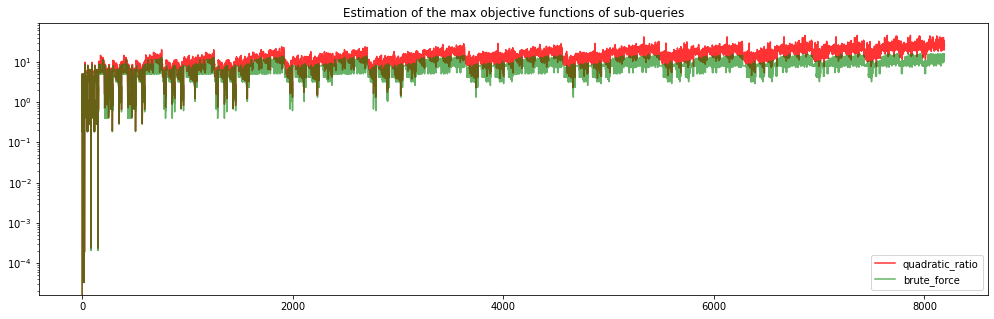

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,5))
plt.plot(list(range(len(quadratic_ratios))), quadratic_ratios,c='r', alpha=0.8, label='quadratic_ratio')
plt.plot(list(range(len(brute))), brute,c='g',alpha=0.6, label='brute_force')
plt.legend()
plt.yscale('log')
plt.title('Estimation of the max objective functions of sub-queries')
plt.show()

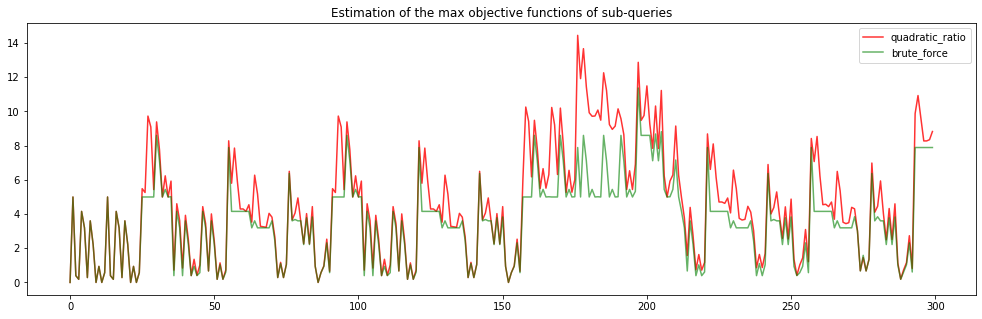

In [32]:
plt.figure(figsize=(17,5))
plt.plot(list(range(300)), quadratic_ratios[:300],c='r', alpha=0.8, label='quadratic_ratio')
plt.plot(list(range(300)), brute[:300],c='g',alpha=0.6, label='brute_force')
plt.legend()
plt.title('Estimation of the max objective functions of sub-queries')
plt.show()

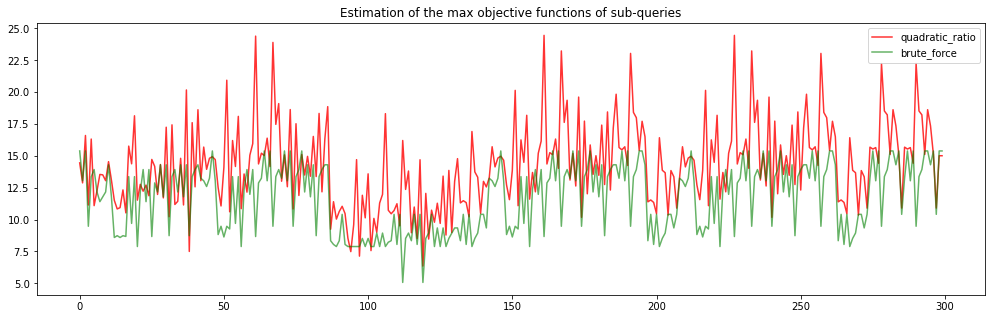

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,5))
plt.plot(list(range(300)), np.array(quadratic_ratios[-300:])/np.log(6),c='r', alpha=0.8, label='quadratic_ratio')
plt.plot(list(range(300)), brute[-300:],c='g',alpha=0.6, label='brute_force')
plt.legend() 
plt.title('Estimation of the max objective functions of sub-queries')
plt.show()

In [ ]:
res = brute_force(inst1)
res.f_star, norm(inst1.g)**2

In [ ]:
res.print_selected_elements_by_score()

In [ ]:
from matplotlib import pyplot as plt

def plot_solutions(res, additional_res=None, additional_res_names=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, tight_layout=True, squeeze=False)
    bf_obj_ = res.gsums**2 / res.op_norms**2
    axs[0, 0].scatter(res.norms**2, bf_obj_)
    axs[0, 1].scatter(res.op_norms**2, bf_obj_)
    axs[0, 2].scatter(res.gsums, bf_obj_)

    additional_res = [] if additional_res is None else additional_res
    additional_res_names = [f'$q_{i}$' for i in range(len(additional_res))]
    all_results = [res] + additional_res
    all_result_names = [r'$q^*$'] + additional_res_names
    all_res_colors = ['red', 'lime', 'gold', 'magenta', 'black', 'gray'][:len(all_results)]
    for res, name, color in zip(all_results, all_result_names, all_res_colors):
        axs[0, 0].scatter(norm(res.q_star)**2, res.f_star, edgecolors=color, facecolors='none', label=name)
        axs[0, 1].scatter(norm(res.inst.M.dot(res.q_star))**2, res.f_star, edgecolors=color, facecolors='none')
        axs[0, 2].scatter(res.q_star.dot(res.inst.g), res.f_star, edgecolors=color, facecolors='none')
    axs[0, 0].set_ylabel(r'$(q^Tg)^2/\|q_\perp\|^2$')
    axs[0, 0].set_xlabel(r'$\|q\|^2$')
    axs[0, 1].set_xlabel(r'$\|q_\perp\|^2$')
    axs[0, 2].set_xlabel(r'$q^Tg$')
    axs[0, 0].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 1].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 2].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 0].legend(loc='upper right')

In [ ]:
plot_solutions(res)

### More Systematic Test

In [ ]:
smaller_instances = []
num_instances = 200
def brute_force_test(epsilon=0):
    smaller_instances_bf_res = []
    smaller_instances_bf_f_stars=np.array([])
    for i in range(num_instances):
        inst = instance.random(15, 5, i)
        res = brute_force(inst, epsilon=epsilon)
        print(i, end='. ')
        res.print_selected_elements_by_score(end=': ')
        print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        smaller_instances.append(inst)
        smaller_instances_bf_res.append(res)
        smaller_instances_bf_f_stars = np.append(smaller_instances_bf_f_stars, res.f_star)
    return smaller_instances_bf_f_stars, smaller_instances_bf_res

In [ ]:
bfe0f, bfe0res = brute_force_test(epsilon=0)

In [ ]:
bfe1e_3f, bfe1e_3res = brute_force_test(epsilon=1e-3)

In [ ]:
bfe1e_2f, bfe1e_2res = brute_force_test(epsilon=1e-2)

In [ ]:
bfe1e_1f, bfe1e_1res = brute_force_test(epsilon=1e-1)

In [ ]:
bfe1f, bfe1res = brute_force_test(epsilon=1)

In [ ]:
bfe10f, bfe10res = brute_force_test(epsilon=10)

## Greedy Performance

In [ ]:
def squared_grad_sum_by_squared_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)**2/(norm(inst.M.dot(q)) + epsilon)**2) if epsilon!=0 or d>1e-5 else 0

def best_in_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    for i in range(1, inst.n+1):
        seq[i, :] = np.copy(seq[i-1, :])
        j_star = -1
        obj_star = float('-inf')
        for j in range(inst.n):
            if seq[i, j]: continue    
            seq[i, j] = 1
            obj = f(seq[i, :], inst, epsilon=epsilon)
            if obj > obj_star:
                j_star = j
                obj_star = obj
            seq[i, j] = 0
        seq[i, j_star] = 1
        objs[i] = obj_star
#         print(seq[i, :])
#     print(objs)
    best_idx = np.argmax(objs)    
    return result(seq[best_idx, :], objs[best_idx], seq, inst)

In [ ]:
smaller_instances_greedy_res = []
smaller_instances_greedy_f_stars=np.array([])
for i in range(num_instances):
    inst = smaller_instances[i]
    res = best_in_greedy(inst)
    res.print_selected_elements_by_score(end=': ')
    print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
    smaller_instances_greedy_res.append(res)
    smaller_instances_greedy_f_stars = np.append(smaller_instances_greedy_f_stars, res.f_star)

Comparing the greedy solution to the optimal solution on our first instance, we say that the greedy algorithm "picked the wrong horse": based on a good objective value for a positive gradient element, it started to grow a solution with positive sum of selected gradient elements whereas the optimum solution selects a negative sum.

### Refined Greedy Strategy with "Signed" Objectives

This suggest to a refined greedy approach to find the optimal solution that runs the greedy algorithm twice, once aiming to find the optimal "positive solution" and once the optimal "negative solution".

Indeed, when working with the non-squared objective function, we can easily split it into a positive and negative part
\begin{equation*}
\max_{q \in {\cal Q}} \frac{|g^Tq|}{\|q_\perp\|} = \max \left\{\max_{q \in {\cal Q}} \frac{g^Tq}{\|q_\perp\|}, \max_{q \in {\cal Q}}\frac{-g^Tq}{\|q_\perp\|} \right\}
\end{equation*}

In [ ]:
def grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

def neg_grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (-q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

In [ ]:
def best_in_greedy_pos_neg(inst, epsilon=0):
    pos = best_in_greedy(inst, epsilon=epsilon, f=grad_sum_by_orth_norm)
    neg = best_in_greedy(inst, epsilon=epsilon, f=neg_grad_sum_by_orth_norm)
    if pos.f_star > neg.f_star:
        res = pos
    else:
        res = neg
    res.f_star = res.f_star**2
    return res

In [ ]:
def greedy_pos_neg_test(epsilon=0):
    smaller_instances_pn_res = []
    smaller_instances_pn_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = best_in_greedy_pos_neg(inst, epsilon=epsilon)
        res.print_selected_elements_by_score(end=': ')
        print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        smaller_instances_pn_res.append(res)
        smaller_instances_pn_f_stars = np.append(smaller_instances_pn_f_stars, res.f_star)
    return smaller_instances_pn_f_stars, smaller_instances_pn_res

In [ ]:
gpne0f, gpne0res = greedy_pos_neg_test(epsilon=0)

In [ ]:
gpne1e_3f, gpne1e_3res = greedy_pos_neg_test(epsilon=1e-3)

In [ ]:
gpne1e_2f, gpne1e_2res = greedy_pos_neg_test(epsilon=1e-2)

In [ ]:
gpne1e_1f, gpne1e_1res = greedy_pos_neg_test(epsilon=1e-1)

In [ ]:
gpne1f, gpne1res = greedy_pos_neg_test(epsilon=1)

In [ ]:
gpne10f, gpne10res = greedy_pos_neg_test(epsilon=10)

In [ ]:
def fast_para_norms_prefix(O, ext):
    deltas = O[ext]
    length = len(ext)
    okqi = np.cumsum(deltas, axis=0)
    q_para_norms = (okqi ** 2).sum(axis=1)
    q_orth_norms_sq = np.abs(np.arange(1, length + 1) - q_para_norms)
    q_orth_norms = np.sqrt(q_orth_norms_sq)
    return q_orth_norms


def pre_order_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    order = np.argsort(inst.g)
    g = inst.g[order]
    O = inst.O[order]
    num_pre = abs(np.cumsum(g))
    num_suf = abs(np.cumsum(g[::-1]))
    ext = np.arange(inst.n)
    qs = fast_para_norms_prefix(O, ext) + epsilon
    qs_neg = fast_para_norms_prefix(O, ext[::-1]) + epsilon
    neg_bounds = np.divide(num_suf, qs_neg, out=np.zeros_like(num_suf), where=qs_neg != 0)
    pos_bounds = np.divide(num_pre, qs, out=np.zeros_like(num_suf), where=qs != 0)
    neg_max = np.argmax(neg_bounds)
    pos_max = np.argmax(pos_bounds)
#     print(pos_bounds)
#     print(neg_bounds)
    if neg_bounds[neg_max]>pos_bounds[pos_max]:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, neg_max+1)
        best_seq[order[selected]]=1
        obj = neg_bounds[neg_max]
    else:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, pos_max+1)
        best_seq[order[::-1][selected]]=1
        obj = pos_bounds[pos_max]
    return result(best_seq, obj**2, seq, inst)

In [ ]:
def pre_order_greedy_test(epsilon=0):
    smaller_instances_pre_res = []
    smaller_instances_pre_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = pre_order_greedy(inst, epsilon=epsilon)
        res.print_selected_elements_by_score(end=': ')
        print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        smaller_instances_pre_res.append(res)
        smaller_instances_pre_f_stars = np.append(smaller_instances_pre_f_stars, res.f_star)
    return smaller_instances_pre_f_stars, smaller_instances_pre_res

In [ ]:
pree0f, pree0res = pre_order_greedy_test(epsilon=0)

In [ ]:
pree1e_3f, pree1e_3res = pre_order_greedy_test(epsilon=1e-3)

In [ ]:
pree1e_2f, pree1e_2res = pre_order_greedy_test(epsilon=1e-2)

In [ ]:
pree1e_1f, pree1e_1res = pre_order_greedy_test(epsilon=1e-1)

In [ ]:
pree1f, pree1res = pre_order_greedy_test(epsilon=1)

In [ ]:
pree10f, pree10res = pre_order_greedy_test(epsilon=10)

In [ ]:
np.linalg.eig(inst.M@inst.M.T)

In [ ]:
np.linalg.eig(inst.M)

In [ ]:
A=inst1.M
A.sum(axis=0)

In [ ]:
Q=inst1.g.reshape(-1,1)@inst1.g.reshape(1,-1)

In [ ]:
P=inst1.M.T@inst1.M

In [ ]:
np.linalg.eig(np.linalg.inv(P)@Q)

In [ ]:
qq

In [ ]:
qq[1]=1

In [ ]:
qq@g/(qq.T@inst1.M.T@inst1.M@qq)

In [ ]:
MM=(inst1.M.T@inst1.M)
qq@g*np.sqrt(qq.sum())/(MM.sum(axis=0)@qq*2)

In [ ]:
((MM>0)*MM).sum()

In [ ]:
((MM<0)*MM).sum()

In [ ]:
MM

### test of projection of g

In [ ]:
L, V=np.linalg.eigh(inst1.M)

In [ ]:
V@np.diag(L)@V.T

In [ ]:
abs(g.T@V@qq)/np.linalg.norm(V@np.diag(L)@qq)

In [ ]:
g@qq/np.linalg.norm(inst1.M@qq)

In [ ]:
QQ = RNG.binomial(1, 0.5, size=(20, 10))
QQ

In [ ]:
for col in QQ.T:
    print(abs(g.T@V@col)/np.linalg.norm(V@np.diag(L)@col))

In [ ]:
for col in QQ.T:
    print(abs(g@col)/np.linalg.norm(inst1.M@col))

In [ ]:
np.linalg.inv(P)@Q

In [ ]:
A@qq

In [ ]:
np.linalg.norm(P.T@qq), np.linalg.norm(qq)

In [ ]:
np.linalg.norm(A@qq)**2

In [ ]:
P@np.diag(la)

In [ ]:
qq.T@np.diag(la)@qq

In [ ]:
qq.T@P@np.diag(la)@P.T@qq

In [ ]:
qq.T@P@np.diag(la)@P.T@qq

In [ ]:
def fast_para_norms_prefix(O, ext):
    deltas = O[ext]
    length = len(ext)
    okqi = np.cumsum(deltas, axis=0)
    q_para_norms = (okqi ** 2).sum(axis=1)
    q_orth_norms_sq = np.abs(np.arange(1, length + 1) - q_para_norms)
    q_orth_norms = np.sqrt(q_orth_norms_sq)
    return q_orth_norms
def pre_order_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    order = np.argsort(inst.g)
    g = inst.g[order]
    O = inst.O[order]
    num_pre = abs(np.cumsum(g))
    num_suf = abs(np.cumsum(g[::-1]))
    ext = np.arange(inst.n)
    qs = fast_para_norms_prefix(O, ext) + epsilon
    qs_neg = fast_para_norms_prefix(O, ext[::-1]) + epsilon
    neg_bounds = np.divide(num_suf, qs_neg, out=np.zeros_like(num_suf), where=qs_neg != 0)
    pos_bounds = np.divide(num_pre, qs, out=np.zeros_like(num_suf), where=qs != 0)
    neg_max = np.argmax(neg_bounds)
    pos_max = np.argmax(pos_bounds)
#     print(pos_bounds)
#     print(neg_bounds)
    if neg_bounds[neg_max]>pos_bounds[pos_max]:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, neg_max+1)
        best_seq[order[selected]]=1
        obj = neg_bounds[neg_max]
    else:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, pos_max+1)
        best_seq[order[::-1][selected]]=1
        obj = pos_bounds[pos_max]
    return result(best_seq, obj**2, seq, inst)

def pre_order_greedy_sum_col(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    s = np.abs(inst.M.sum(axis=0))
    order = np.argsort(inst.g/s)
    g = inst.g[order]
    O = inst.O[order]
    M = np.eye(inst.n) - O.dot(O.T)
    ss = M.sum(axis=0)
    sss=M.sum()
    num_pre = abs(np.cumsum(g))
    num_suf = abs(np.cumsum(g[::-1]))
    ext = np.arange(inst.n)
    qs = fast_para_norms_prefix(O, ext) + epsilon
    qs_neg = fast_para_norms_prefix(O, ext[::-1]) + epsilon
    neg_bounds = np.divide(num_suf, qs_neg, out=np.zeros_like(num_suf), where=qs_neg != 0)
    pos_bounds = np.divide(num_pre, qs, out=np.zeros_like(num_suf), where=qs != 0)
    neg_max = np.argmax(neg_bounds)
    pos_max = np.argmax(pos_bounds)
#     print(pos_bounds)
#     print(neg_bounds)
    if neg_bounds[neg_max]>pos_bounds[pos_max]:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, neg_max+1)
        best_seq[order[selected]]=1
        obj = neg_bounds[neg_max]
    else:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, pos_max+1)
        best_seq[order[::-1][selected]]=1
        obj = pos_bounds[pos_max]
    return result(best_seq, obj**2, seq, inst)

In [ ]:
def pre_order_greedy_sum_col_test(epsilon=0):
    smaller_instances_pre_res = []
    smaller_instances_pre_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = pre_order_greedy_sum_col(inst, epsilon=epsilon)
        res.print_selected_elements_by_score(end=': ')
        print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        smaller_instances_pre_res.append(res)
        smaller_instances_pre_f_stars = np.append(smaller_instances_pre_f_stars, res.f_star)
    return smaller_instances_pre_f_stars, smaller_instances_pre_res

In [ ]:
presce1e_3f, prscee1e_3res=pre_order_greedy_sum_col_test(epsilon=0.001)

In [ ]:
presce0f, presce0res = pre_order_greedy_sum_col_test(epsilon=0)

In [ ]:
presce1e_2f, prscee1e_2res=pre_order_greedy_sum_col_test(epsilon=0.01)

In [ ]:
presce1e_1f, prscee1e_1res=pre_order_greedy_sum_col_test(epsilon=0.1)

In [ ]:
presce1f, prscee1res=pre_order_greedy_sum_col_test(epsilon=1)

In [ ]:
presce10f, prscee10res=pre_order_greedy_sum_col_test(epsilon=10)

In [ ]:
ratio_pn1e_3 = gpne1e_3f / bfe1e_3f
ratio_pre1e_3 = pree1e_3f / bfe1e_3f
ratio_presc1e_3 = presce1e_3f / bfe1e_3f
ratio_pn1e_3, ratio_pre1e_3, ratio_presc1e_3

In [ ]:
ratio_pn1e_1 = gpne1e_1f / bfe1e_1f
ratio_pre1e_1 = pree1e_1f / bfe1e_1f
ratio_presc1e_1 = presce1e_1f / bfe1e_1f
ratio_pn1e_1, ratio_pre1e_1, ratio_presc1e_1

In [ ]:
ratio_pn1 = gpne1f / bfe1f
ratio_pre1 = pree1f / bfe1f
ratio_presc1 = presce1f / bfe1f
ratio_pn1, ratio_pre1, ratio_presc1

In [ ]:
from matplotlib import pyplot as plt

def plot_hists(res_pns, res_pres, res_prescs, filename):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True, tight_layout=True, squeeze=False)
    for i in range(3):
        heights_pre, bins = np.histogram(res_pres[i], 20, range=(0.75, 1))
#         print(heights_pre)
        heights_pn, _ = np.histogram(res_pns[i], bins)
#         print(heights_pn)
        heights_pre, bins = np.histogram(res_pres[i], 20, range=(0.75, 1))
#         print(heights_pre)
        heights_pre_cs, _ = np.histogram(res_prescs[i], bins)
#         print(res_prescs)
        axs[0, i].bar(bins[1:], heights_pre/2, label = 'pre-sort greedy', edgecolor='blue', align="edge",alpha=0.6, **kwargs)
        axs[0, i].bar(bins[1:], heights_pn/2, label='greedy', align="edge", edgecolor='orange',alpha=0.5,  **kwargs)
        axs[0, i].bar(bins[1:], heights_pre_cs/2, label='greedy cs', align="edge", edgecolor='yellow',alpha=0.5,  **kwargs)
        axs[0, i].grid()
#         axs[0, i].set_yscale('log')
        vals = axs[0, i].get_yticks()
        axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])
    axs[0, 0].set_xlabel(r"$obj_{g}(q)/obj^*(q)$")
    axs[0, 0].set_title(r"$\epsilon=0.001$")
    axs[0, 1].set_title(r"$\epsilon=0.1$")
    axs[0, 2].set_title(r"$\epsilon=1$")
    axs[0, 0].set_ylabel(r'Ratio of instances')
    axs[0, 0].legend(loc='upper left')
    fig.savefig(filename)
plot_hists([ratio_pn1e_3, ratio_pn1e_1, ratio_pn1], [ratio_pre1e_3, ratio_pre1e_1, ratio_pre1],
           [ratio_presc1e_3, ratio_presc1e_1, ratio_presc1], filename='combined_greedy.pdf')

In [ ]:
ratio_pn0 = gpne0f / bfe0f
ratio_pre0 = pree0f / bfe0f
ratio_pn0, ratio_pre0

In [ ]:
ratio_pn1e_3 = gpne1e_3f / bfe1e_3f
ratio_pre1e_3 = pree1e_3f / bfe1e_3f
ratio_pn1e_3, ratio_pre1e_3

In [ ]:
ratio_pn1e_2 = gpne1e_2f / bfe1e_2f
ratio_pre1e_2 = pree1e_2f / bfe1e_2f
ratio_pn1e_2, ratio_pre1e_2

In [ ]:
ratio_pn1e_1 = gpne1e_1f / bfe1e_1f
ratio_pre1e_1 = pree1e_1f / bfe1e_1f
ratio_pn1e_1, ratio_pre1e_1

In [ ]:
ratio_pn1 = gpne1f / bfe1f
ratio_pre1 = pree1f / bfe1f
ratio_pn1, ratio_pre1

In [ ]:
ratio_pn10 = gpne10f / bfe10f
ratio_pre10 = pree10f / bfe10f
ratio_pn10, ratio_pre10

In [ ]:
kwargs = dict(width=0.25/20)

In [ ]:
from matplotlib import pyplot as plt

def plot_hists(res_pns, res_pres, filename):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True, tight_layout=True, squeeze=False)
    for i in range(3):
        heights_pre, bins = np.histogram(res_pres[i], 20, range=(0.75, 1))
        print(heights_pre)
        heights_pn, _ = np.histogram(res_pns[i], bins)
        print(heights_pn)
        axs[0, i].bar(bins[1:], heights_pre/2, label = 'pre-sort greedy', edgecolor='blue', align="edge",alpha=0.6, **kwargs)
        axs[0, i].bar(bins[1:], heights_pn/2, label='greedy', align="edge", edgecolor='orange',alpha=0.5,  **kwargs)
        axs[0, i].grid()
#         axs[0, i].set_yscale('log')
        vals = axs[0, i].get_yticks()
        axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])
    axs[0, 0].set_xlabel(r"$obj_{g}(q)/obj^*(q)$")
    axs[0, 0].set_title(r"$\epsilon=0.001$")
    axs[0, 1].set_title(r"$\epsilon=0.1$")
    axs[0, 2].set_title(r"$\epsilon=1$")
    axs[0, 0].set_ylabel(r'Ratio of instances')
    axs[0, 0].legend(loc='upper left')
    fig.savefig(filename)
plot_hists([ratio_pn1e_3, ratio_pn1e_1, ratio_pn1], [ratio_pre1e_3, ratio_pre1e_1, ratio_pre1], filename='combined_greedy.pdf')

In [ ]:
plt.hist([ratio_pn0, ratio_pre0], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn0.pdf")

In [ ]:
plt.hist([ratio_pn1e_3, ratio_pre1e_3], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_3.pdf")

In [ ]:
plt.hist([ratio_pn1e_2, ratio_pre1e_2], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_2.pdf")

In [ ]:
plt.hist([ratio_pn1e_1, ratio_pre1e_1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_1.pdf")

In [ ]:
plt.hist([ratio_pn1, ratio_pre1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e0.pdf")

In [ ]:
plt.hist([ratio_pn10, ratio_pre10], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn10.pdf")

In [ ]:
1/0
# Stop here

In [ ]:
plt.hist([ratio], label=['greedy (ps)'], histtype='bar', log=True, density=True)
plt.grid()
# plt.legend()
plt.ylabel("Density of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn.pdf")

In [ ]:
ratio_greedy.min()

In [ ]:
plt.hist(ratio_greedy)

In [ ]:
smaller_instances_ref_greedy_res = []

for inst in smaller_instances:
    res1 = best_in_greedy(inst, f=grad_sum_by_orth_norm)
    res2 = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
    res = res1 if res1.f_star >= res2.f_star else res2
    res.f_star = res.f_star**2
    smaller_instances_ref_greedy_res.append(res)

In [ ]:
import math

def compare_results_by_score(inst, *results):
    for res in results:
        res.print_selected_elements_by_score(end=': ')
        print(f'{res.f_star}')

subopt_instances = []
subopt_relgaps = []
for i, (inst, res_bf, res_greedy) in enumerate(zip(smaller_instances, smaller_instances_bf_res, smaller_instances_ref_greedy_res)):
    if not math.isclose(res_bf.f_star, res_greedy.f_star):
        gap = (res_bf.f_star - res_greedy.f_star)/res_bf.f_star
        # print('refined greedy suboptimal on instance', i, 'by', gap)
        subopt_instances.append(i)
        subopt_relgaps.append(gap)
        # compare_results_by_score(inst, res_bf, res_greedy)
    # plot_solutions(smaller_instances_bf_res[0])

subopt_instances = np.array(subopt_instances)
subopt_relgaps = np.array(subopt_relgaps)

print(len(subopt_instances), 'instances where greedy is suboptimal')
order = np.argsort(subopt_relgaps)[::-1]
print('the 10 most severe are: ')
print(subopt_instances[order[:10]])
print(subopt_relgaps[order[:10]])

In [ ]:
inst, res_bf, res_greedy = smaller_instances[10], smaller_instances_bf_res[10], smaller_instances_ref_greedy_res[10]
compare_results_by_score(inst, res_bf, res_greedy)
plot_solutions(smaller_instances_bf_res[10], additional_res=[res_greedy])


In [ ]:
res_greedy_neg = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
res_greedy_neg.print_selected_elements_by_score()
print(res_greedy_neg.f_star**2)
print(norm(inst.M.dot(res_greedy_neg.q_star)))
print(norm(inst.M.dot(res_bf.q_star)))

In [ ]:
plot_solutions(smaller_instances_bf_res[69], [smaller_instances_ref_greedy_res[69]])

In [ ]:
plot_solutions(smaller_instances_bf_res[3], [smaller_instances_ref_greedy_res[3]])

### Intermediate Conclusion

Despite an overall very good performance, it seems that the refined greedy algorithm does not guarantee to find the optimal solution. Eight of the 30/100 optimality violations can be attributed to numerical instability where the optimal solution is either incorrect or at least pointing to a weaknesses of the objective function itself. The other 22 appear to be genuine problems with the largest relative performance gap of about 11%.

In any case, the numerical instability motivates regularising the objective function, and it is a possibility that such regularization will also further improve the performance of the greedy algorithm outside of strictly pathological instances.

## Regularised Objective Function

Because we are interested int the signed version of the objective function for the greedy algorithm, it makes sense to apply regularization to the non-squared version:

\begin{align*}
\frac{|g^Tq|}{\|q_\perp\|+\epsilon} &\leq \frac{|g^q|}{|g^Tq|/\|g\| + \epsilon}\\
&= \frac{\|g\|}{1 + \epsilon \|g\| / |g^Tq|}
\end{align*}


## Old

In [ ]:
def compare_results_by_score(inst, res):
    res.print_selected_elements_by_score(end=': ')
    print(f'{res.f_star}')
    res1 = best_in_greedy(inst)
    res1.print_selected_elements_by_score(end=': ')
    print(res1.f_star)
    res2 = best_in_greedy(inst, f=grad_sum_by_orth_norm)
    res2.print_selected_elements_by_score(end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res2.q_star, inst))
    res3 = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
    res3.print_selected_elements_by_score(end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res3.q_star, inst))
    print()

for i, (inst, bf_res) in zip(smaller_instances, smaller_instances_bf_res):
    compare_results_by_score(inst, res)

In [ ]:
inst = smaller_instances[1]
for i in range(0, inst.n+1):
    res = best_in_greedy(inst)
    inst.print_selected_elements_by_score(res.q_seq[i], end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res.q_seq[i], inst))

In [ ]:
from matplotlib import pyplot as plt

def plot_solutions(inst):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, tight_layout=True, squeeze=False)
    bf_obj_ = inst.bf_gsum_**2 / inst.bf_opn_**2
    axs[0, 0].scatter(inst.bf_norms_**2, bf_obj_)
    axs[0, 1].scatter(inst.bf_opn_**2, bf_obj_)
    axs[0, 2].scatter(inst.bf_gsum_, bf_obj_)
    axs[0, 0].scatter(norm(inst.q_star)**2, inst.obj_star, edgecolors='red', facecolors='none', label=r'$q^*$')
    axs[0, 1].scatter(norm(inst.M.dot(inst.q_star))**2, inst.obj_star, edgecolors='red', facecolors='none')
    axs[0, 2].scatter(inst.q_star.dot(inst.g), inst.obj_star, edgecolors='red', facecolors='none')
    axs[0, 0].set_ylabel(r'$(q^Tg)^2/\|q_\perp\|^2$')
    axs[0, 0].set_xlabel(r'$\|q\|^2$')
    axs[0, 1].set_xlabel(r'$\|q_\perp\|^2$')
    axs[0, 2].set_xlabel(r'$q^Tg$')
    axs[0, 0].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 1].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 2].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 0].legend(loc='upper right')

plot_solutions(inst1)
plt.show()

In [ ]:
plot_solutions(smaller_instances[3])

In [ ]:
R = np.triu(np.ones(shape=(n, n)))
(M.dot(R)**2).sum(axis=0)

In [ ]:
(M.dot(np.eye(n))**2).sum(axis=0)

In [ ]:
order = np.argsort(((np.eye(n) - O.dot(O.T)).dot(np.eye(n))**2).sum(axis=0))
order

In [ ]:
point_orth_scores = (M.dot(np.eye(n))**2).sum(axis=0)
point_orth_scores

In [ ]:
point_par_scores = (P.dot(np.eye(n))**2).sum(axis=0)
point_par_scores

In [ ]:
R = np.cumsum(np.eye(n)[order, :], axis=0).T
R[:, : 4]

In [ ]:
(M.dot(R)**2).sum(axis=0)

In [ ]:
g

In [ ]:
order = np.argsort(g)[::-1]
g[order]

In [ ]:
R = np.cumsum(np.eye(n)[order, :], axis=0).T
R[:, : 4]

In [ ]:
def prefix_matrix(order):
    return np.cumsum(np.eye(n)[order, :], axis=0).T

def obj_values_of_prefixes(order):
    R = prefix_matrix(order)
    return g.dot(R)**2 / (M.dot(R)**2).sum(axis=0)

In [ ]:
def squared_proj_length(queries):
    return (M.dot(queries)**2).sum(axis=0)

In [ ]:
def obj(queries):
    return g.dot(queries)**2 / squared_proj_length(queries)

In [ ]:
from itertools import combinations

def non_empty_subset_indicator(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            yield col

def non_empty_subset_matrix(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    res = np.zeros(shape=(d, 2**len(idx)-1))
    j = 0
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            res[:, j] = col
            j+= 1
    return res

In [ ]:
# bfc_spl = squared_proj_length(bfc)
# g_sum = g.dot(bfc)

bfcg_gsum = np.zeros(2**n-1)
bfcg_spl = np.zeros(2**n-1)

for i, q in enumerate(non_empty_subset_indicator(20)):
    bfcg_gsum[i]=g.dot(q)
    bfcg_spl[i]=squared_proj_length(q)
    

In [ ]:
from matplotlib import pyplot as plt

bfc = non_empty_subset_matrix(n)
bfc_spl = squared_proj_length(bfc)
bfc_gsum = g.dot(bfc)
plt.scatter(bfc_spl[:], bfc_gsum[:]**2/bfc_spl[:], alpha=0.5)
plt.show()

In [ ]:
bfc_obj = bfc_gsum**2 / bfc_spl
np.argmax(bfc_obj)

In [ ]:
(bfcg_spl - bfc_spl).max()

In [ ]:
bfc_obj[np.argmax(bfc_obj)]

In [ ]:
q_max = bfc[:, np.argmax(bfc_obj)]
q_max

In [ ]:
np.flatnonzero(q_max)

In [ ]:
g[np.flatnonzero(q_max)]

In [ ]:
q_max_ = np.copy(q_max)
q_max_[7] = 0
q_max_

In [ ]:
g[np.flatnonzero(q_max_)].sum()**2

In [ ]:
g.dot(q_max)**2, squared_proj_length(q_max), g.dot(q_max)**2/squared_proj_length(q_max)

In [ ]:
g.dot(q_max_)**2, squared_proj_length(q_max_), g.dot(q_max_)**2/squared_proj_length(q_max_)

In [ ]:
np.sort(g[np.flatnonzero(bfc[:, np.argmax(bfc_obj)])])

In [ ]:
np.sort(g)

In [ ]:
norm(g)**2

In [ ]:
i_min_spl = np.argmin(bfc_spl)
i_min_spl

In [ ]:
q_min_spl = bfc[:, i_min_spl]
q_min_spl

In [ ]:
(M.dot(q_min_spl)**2).sum()

In [ ]:
g.dot(q_min_spl) / (M.dot(q_min_spl)**2).sum()

In [ ]:
g.dot(bfc)[i_min_spl]**2

In [ ]:
bfc_spl[np.argmin(bfc_spl[1:])]

In [ ]:
np.argmin(bfc_spl[1:])

In [ ]:
bfc_spl[1:][np.argmin(bfc_spl[1:])]

In [ ]:
M.dot(q_min)

In [ ]:
g.dot(bfc[:, np.argmin(bfc_spl[1:])])

In [ ]:
prefix_matrix(np.arange(4))

In [ ]:
g.dot(prefix_matrix(np.arange(10)))**2

In [ ]:
M.dot(prefix_matrix(np.arange(10)))

In [ ]:
g.dot(powerset_matrix(20))

In [ ]:
R = prefix_matrix(np.argsort(g)[::-1])
g.T.dot(R)**2 / (M.dot(R)**2).sum(axis=0)

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
from itertools import combinations

def non_empty_subset_matrix(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    res = np.zeros(shape=(d, 2**len(idx)-1))
    j = 0
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            res[:, j] = col
            j+= 1
    return res

non_empty_subset_matrix(20, np.arange(10)).shape

In [ ]:
(M.dot(prefix_matrix(np.argsort(point_orth_scores)[::-1]))**2).sum(axis=0)

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g)[::-1]))

In [ ]:
obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1])

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1]))

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g)[::-1]))
plt.plot(obj_values_of_prefixes(np.argsort(g*point_par_scores / point_orth_scores)[::1]), label='$ge_\par/$')
plt.plot(obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1]))
plt.legend()

In [ ]:
g[np.argsort(g)[::-1]]

In [ ]:
g.dot(prefix_matrix(np.argsort(g)[::-1]))

In [ ]:
prefix_matrix(np.arange(n))[:,:4]

In [ ]:
denom = (M.dot(R)**2).sum(axis=0)
denom

In [ ]:
g.dot(R), np.cumsum(g[order])

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
(g / point_orth_scores**0.5)[np.argsort(g / point_orth_scores**0.5)[::-1]]

In [ ]:
obj_values_of_prefixes(np.argsort(g / point_par_scores)[::-1])

In [ ]:
g.dot(R)/denom

In [ ]:
O.T.dot(O)

In [ ]:
G = Q.T.dot(Q)
G

In [ ]:
G_inv = np.linalg.inv(G)
G_inv

In [ ]:
q1 = RNG.binomial(1, 0.8, size=20)
q2 = RNG.binomial(1, 0.2, size=20)
q1, q2

In [ ]:
def decomp(Q, q):
    G = Q.T.dot(Q)
    G_inv = np.linalg.inv(G)
    q_proj = Q.dot(G_inv.dot(Q.T.dot(q)))
    return q_proj, q-q_proj

In [ ]:
np.linalg.norm(q1)**2

In [ ]:
from numpy.linalg import norm

q1_par, q1_orth = decomp(Q, q1)
q2_par, q2_orth = decomp(Q, q2)

norm(q1_par), norm(q2_par)

In [ ]:
q1_par, q1_orth

In [ ]:
r = 1000
covs = np.zeros(r)
par_norms = np.zeros(r)
orth_norms = np.zeros(r)

for i in range(r):
    q = RNG.binomial(1, 0.5, 20)
    covs[i] = sum(q)
    q1_par, q1_orth = decomp(Q, q)
    par_norms[i] = norm(q1_par)
    orth_norms[i] = norm(q1_par)

norms = covs**0.5


In [ ]:
q_all_par, q_all_orth = decomp(Q, np.ones(20))

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(norms, par_norms)
plt.scatter([norm(np.ones(20))], [norm(q_all_par)])
plt.plot([1, 4.6], [1, 4.6])
plt.margins(x=0, y=0)
plt.ylabel('$\|q_\parallel\|$')
plt.xlabel('$\|q\|$')
plt.show()